
# TP – Prédire le taux d’utilisation CPU d’un serveur à partir d’indicateurs réseau

**Objectif pédagogique :** construire, expliquer et évaluer un modèle de **régression** qui anticipe la **charge CPU** d’un serveur à partir d’indicateurs réseau, comme on le ferait dans un **SOC (Security Operations Center)** pour détecter des surcharges (ex. DDoS) et comportements anormaux.

## Plan
1. Contexte de l’étude  
2. Importations & données (simulation réaliste)  
3. Exploration & pré‑traitement  
   - Aperçu & valeurs manquantes  
   - Analyse de corrélation  
   - Encodage (rappel) & Standardisation  
4. Train/Test split  
5. Sélection séquentielle de variables (**SequentialFeatureSelector**)  
6. Ajustement du modèle (régression linéaire) et évaluation  
7. Amélioration par interactions (**PolynomialFeatures**) et ré‑évaluation  
8. Recommandations


In [5]:

# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector



## 2) Données : simulation réaliste (logs réseau)
Dans un contexte SOC, on observe par **intervalle de temps** :
- `tcp_connections` : nb de connexions TCP actives  
- `data_volume_MB` : volume transmis (Mo)  
- `packet_loss_rate` : taux de perte de paquets (%)  
- `ids_alerts` : nb d’alertes IDS  
- `cpu_load` : charge CPU (cible à prédire)

> Ici, on **simule** un jeu de données cohérent avec du bruit pour pratiquer la modélisation.


In [6]:
data=pd.read_csv("data/cpu_load_data.csv")


## 3) Exploration & pré‑traitement
### 3.1 Aperçu général & qualité des données
- Vérifier formats, valeurs manquantes, statistiques descriptives.


In [7]:

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tcp_connections   500 non-null    int64  
 1   data_volume_MB    500 non-null    float64
 2   packet_loss_rate  500 non-null    float64
 3   ids_alerts        500 non-null    int64  
 4   cpu_load          500 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.7 KB


In [8]:

data.describe().T


,count,mean,std,min,25%,50%,75%,max
tcp_connections,500.0,1055.626000,554.832927,51.000000,594.500000,1083.000000,1534.250000,1995.000000
data_volume_MB,500.0,5020.209236,2899.730516,207.292750,2526.350630,5078.990411,7550.991890,9997.204966
packet_loss_rate,500.0,2.526169,1.474920,0.023160,1.167228,2.578816,3.822507,4.989671
ids_alerts,500.0,24.964000,14.757041,0.000000,12.000000,25.000000,38.000000,49.000000
cpu_load,500.0,74.092776,37.119868,3.925035,45.454861,67.256479,100.025005,179.353562



### 3.2 Analyse de corrélation
- But : estimer la **force des relations linéaires** entre variables.  
- Outil : matrice des corrélations de Pearson.  
> **Rappel :** La corrélation ≠ causalité ; elle guide le choix de variables et l'interprétation.


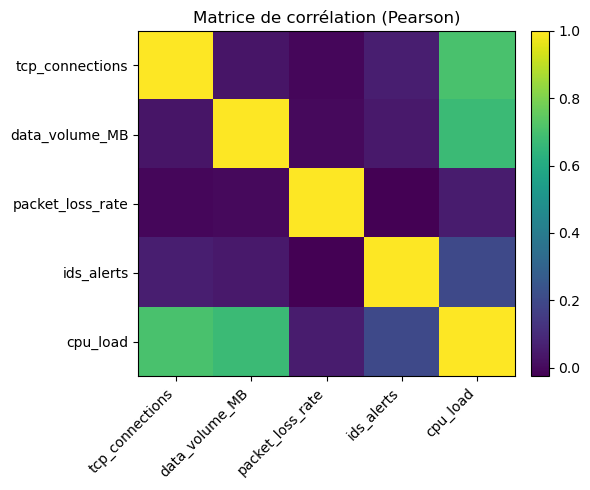

,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts,cpu_load
tcp_connections,1.000000,0.033174,-0.006054,0.059123,0.703904
data_volume_MB,0.033174,1.000000,0.002097,0.046343,0.672804
packet_loss_rate,-0.006054,0.002097,1.000000,-0.025694,0.053471
ids_alerts,0.059123,0.046343,-0.025694,1.000000,0.199409
cpu_load,0.703904,0.672804,0.053471,0.199409,1.000000


In [9]:

# Matrice de corrélation
corr = data.corr(numeric_only=True)

# Visualisation avec matplotlib (pas de seaborn, 1 plot par figure, couleurs par défaut)
plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, aspect='auto', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matrice de corrélation (Pearson)")
plt.tight_layout()
plt.show()

corr



### 3.3 Encodage des variables qualitatives (rappel)
Si vous aviez des colonnes **catégorielles** (`type_proto`, `zone`, etc.), utilisez `pd.get_dummies(..., drop_first=True)` ou `OneHotEncoder`.  
Ici, toutes les variables sont **numériques**, donc pas d’encodage à faire.

### 3.4 Standardisation
- Les variables sont sur des **échelles différentes** (Mo, %, compte…).  
- On **standardise** pour améliorer la stabilité de l’entraînement.


In [10]:

X = data.drop(columns=["cpu_load"])
y = data["cpu_load"].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Garder les noms de features pour le suivi
feature_names = X.columns.tolist()

X.head()


,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts
0,1176,8785.993412,0.167662,7
1,1509,7433.609316,2.849448,20
2,910,7000.455836,3.812293,17
3,1344,7054.592431,4.383828,29
4,1180,3658.962397,1.710409,17



## 4) Train/Test split
On sépare les données pour **évaluer la généralisation** du modèle.


In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((400, 4), (100, 4))


## 5) Sélection séquentielle de variables (**SequentialFeatureSelector**)
**Idée :** choisir automatiquement un sous‑ensemble pertinent de variables pour limiter la complexité et le sur‑ajustement.

- `direction="forward"` : on **ajoute** les variables les plus utiles une à une  
- `n_features_to_select=3` (modifiable pour expérimenter)


In [12]:

linreg = LinearRegression()
sfs = SequentialFeatureSelector(linreg, n_features_to_select=3, direction="forward")
sfs.fit(X_train, y_train)

support_mask = sfs.get_support()
selected_features = [name for name, keep in zip(feature_names, support_mask) if keep]
selected_features


['tcp_connections', 'data_volume_MB', 'ids_alerts']


## 6) Ajustement du modèle linéaire & évaluation
On ajuste la **régression linéaire** avec les **variables sélectionnées**, puis on évalue sur le **jeu de test**.


In [13]:

# Filtrer les colonnes sélectionnées
X_train_sfs = X_train[:, support_mask]
X_test_sfs  = X_test[:, support_mask]

linreg.fit(X_train_sfs, y_train)
y_pred = linreg.predict(X_test_sfs)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2   = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


MAE  : 8.73
RMSE : 11.02
R²   : 0.909


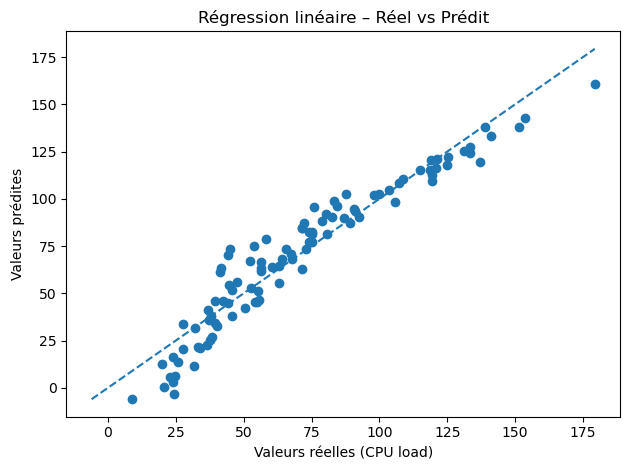

In [14]:

# Nuage réel vs prédit (1 figure, pas de style/couleurs spécifiques)
plt.figure()
plt.scatter(y_test, y_pred)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("Valeurs réelles (CPU load)")
plt.ylabel("Valeurs prédites")
plt.title("Régression linéaire – Réel vs Prédit")
plt.tight_layout()
plt.show()



## 7) Amélioration : interactions (**PolynomialFeatures**)
Les **interactions** (produits entre variables) modélisent des effets combinés (ex. trafic élevé × pertes de paquets).  
Ici, on génère toutes les **caractéristiques polynomiales de degré 2** (sans biais), puis on ré‑entraîne un modèle linéaire.


In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

linreg_poly = LinearRegression()
linreg_poly.fit(X_train_p, y_train_p)
y_pred_p = linreg_poly.predict(X_test_p)

mae_p  = mean_absolute_error(y_test_p, y_pred_p)
rmse_p = mean_squared_error(y_test_p, y_pred_p) ** 0.5
r2_p   = r2_score(y_test_p, y_pred_p)

print(f"MAE (poly)  : {mae_p:.2f}")
print(f"RMSE (poly) : {rmse_p:.2f}")
print(f"R² (poly)   : {r2_p:.3f}")

MAE (poly)  : 4.40
RMSE (poly) : 5.26
R² (poly)   : 0.979


In [16]:
# Analyse des coefficients du modèle polynomial
pd.DataFrame({"Variables": poly.get_feature_names_out(input_features=X.columns).tolist(), 
             "Coef": linreg_poly.coef_}).sort_values(by="Coef", key=abs, ascending=False)

,Variables,Coef
0,tcp_connections,24.836723
1,data_volume_MB,24.392138
5,tcp_connections data_volume_MB,7.838466
3,ids_alerts,5.002725
2,packet_loss_rate,2.051327
4,tcp_connections^2,-0.331058
12,packet_loss_rate ids_alerts,0.270469
9,data_volume_MB packet_loss_rate,-0.185099
11,packet_loss_rate^2,-0.175130
7,tcp_connections ids_alerts,0.104790


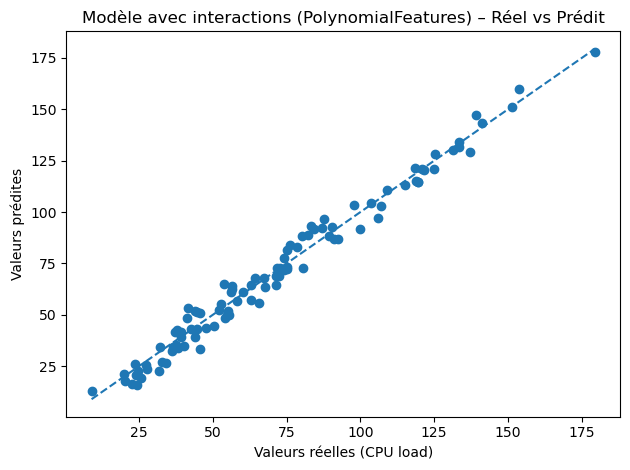

In [17]:
# Nuage réel vs prédit – modèle avec interactions
plt.figure()
plt.scatter(y_test_p, y_pred_p)
min_v = min(y_test_p.min(), y_pred_p.min())
max_v = max(y_test_p.max(), y_pred_p.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("Valeurs réelles (CPU load)")
plt.ylabel("Valeurs prédites")
plt.title("Modèle avec interactions (PolynomialFeatures) – Réel vs Prédit")
plt.tight_layout()
plt.show()


## 8) Recommandations
- **Interprétation des coefficients** : examiner l’influence de chaque indicateur pour expliquer la charge CPU (utile en SOC).  
- **Interactions** : si la performance s’améliore, conserver quelques interactions pertinentes plutôt que toutes (risque de sur‑ajustement).  
- **Modèles alternatifs** : tester des approches non linéaires (`KNN`, `RandomForestRegressor`, `XGBoost`).   
- **Validation plus robuste** : utiliser une **validation croisée** et un **pipeline** scikit‑learn (scaler + sélection + modèle).


## 9) Travail à faire KNN (`KNeighborsRegressor()`)

1. Construisez un pipeline complet combinant les étapes suivantes :

    - Standardisation des variables d’entrée (`StandardScaler`)
    - Génération de caractéristiques non linéaires (`PolynomialFeatures`)
    - Sélection automatique de variables (`SequentialFeatureSelector`)
    - Modèle final de régression (`KNeighborsRegressor`)

2. Définissez ensuite une `grille` d’hyperparamètres  :

    - "n_features_to_select": [2, 3, 4, 5] # pour tester différents nombres de variables sélectionnées
    - "n_neighbors": [3, 5, 7, 9, 11, 13, 15]

3. Mettez en place un `GridSearchCV` pour identifier la combinaison optimale des hyperparamètres en utilisant la validation croisée et le score R²